In [11]:
from datetime import datetime, timezone, timedelta
import requests
import json, sys, os
import numpy as np
import pandas as pd
import urllib3
import calendar
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning)
sys.path.append(os.path.abspath(os.path.join('..')))

import matplotlib.pyplot as plt

crw = 'https://tools.izmiran.ru/w/api'


from server.src.scripts.user_select_muon import select_muon_corrected

dt_from = datetime(2024, 1, 1)
dt_to = datetime(2025, 1, 1)

data = select_muon_corrected(dt_from, dt_to, experiment='Moscow-pioneer', query=['corrected'])

df = pd.DataFrame(data,  columns=['time', 'cnt'])
base = 720
df['var'] = (df['cnt'] - base) / base * 100
df

,time,cnt,var
0,2024-01-01 00:00:00+00:00,717.49,-0.348611
1,2024-01-01 01:00:00+00:00,712.84,-0.994444
2,2024-01-01 02:00:00+00:00,716.94,-0.425
3,2024-01-01 03:00:00+00:00,715.88,-0.572222
4,2024-01-01 04:00:00+00:00,715.16,-0.672222
...,...,...,...
8780,2024-12-31 20:00:00+00:00,694.98,-3.475
8781,2024-12-31 21:00:00+00:00,692.24,-3.855556
8782,2024-12-31 22:00:00+00:00,694.06,-3.602778
8783,2024-12-31 23:00:00+00:00,692.31,-3.845833


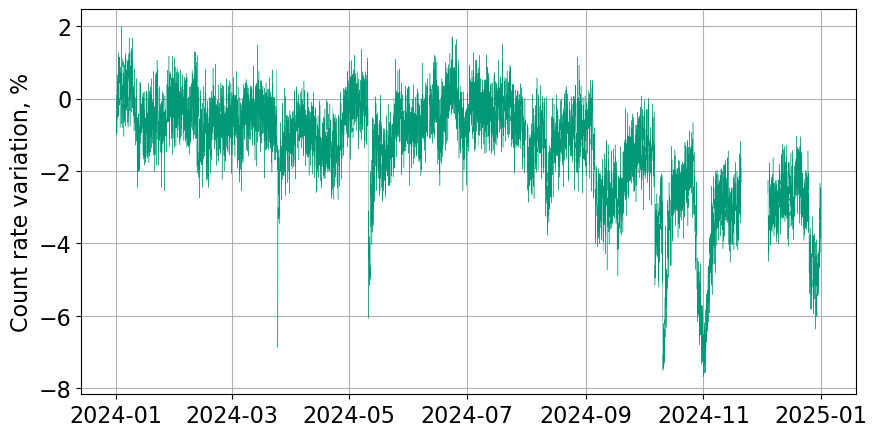

In [12]:
plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['time'], df['var'], linewidth=.3, color="#009977")
ax.set_ylabel('Count rate variation, %')

plt.grid()
plt.show()
fig.savefig('tmp.png', dpi=800, bbox_inches='tight', pad_inches=0)


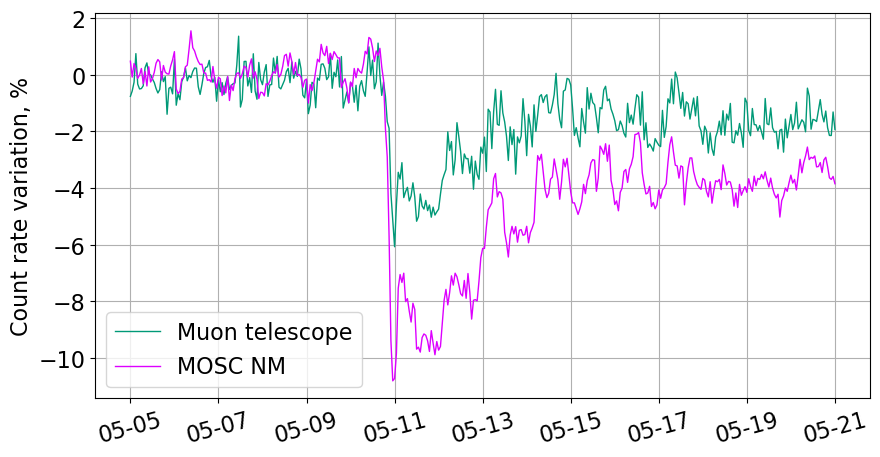

In [13]:
dt_from = datetime(2024, 5, 5)
dt_to = datetime(2024, 5, 21)
tfr, tto = [int(d.replace(tzinfo=timezone.utc).timestamp()) for d in (dt_from, dt_to)]
uri = f'https://tools.izmiran.ru/w/api/neutron/?from={tfr}&to={tto}&stations=MOSC'
res = requests.get(uri, verify=False, timeout=10000)
body = json.loads(res.text)
data = np.array(body.get('rows'), dtype='object')
ndf = pd.DataFrame(data,  columns=['time', 'neutron'])
ndf['time'] = pd.to_datetime(ndf['time'], utc=True, unit='s')

md = select_muon_corrected(dt_from, dt_to, experiment='Moscow-pioneer', query=['corrected'])
df = pd.DataFrame(md,  columns=['time', 'muon'])
df['time'] = pd.to_datetime(df['time'], utc=True, unit='s')
df = df.merge(ndf, on='time')
base = 720
df['mt_var'] = (df['muon'] - base) / base * 100
base = 143
df['nm_var'] = (df['neutron'] - base) / base * 100
df

plt.rcParams.update({'font.size': 16})
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df['time'], df['mt_var'], linewidth=1, color="#009977", label="Muon telescope")
ax.plot(df['time'], df['nm_var'], linewidth=1, color="#dd00ff", label="MOSC NM")
ax.set_ylabel('Count rate variation, %')
ax.legend()
import matplotlib.dates as mdates
ax.xaxis.set_major_formatter(mdates.DateFormatter('%m-%d'))

plt.setp(ax.get_xticklabels(), rotation=15)
plt.grid()
plt.show()
fig.savefig('tmp.png', dpi=800, bbox_inches='tight', pad_inches=0)
